In [1]:
# Dependencies and Setup
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt

# File to Load 
mongo = MongoClient(port=27017)

# Declare the database
for dbname in mongo.list_database_names():
    print(dbname, "<--------" if dbname=='remote' else "")


MongoClient 
admin 
config 
epa 
fruits_db 
local 
met 
remote_work_db 
uk_food 


In [2]:
db = mongo['remote']
collection = db['collectionName']
# review the collections in our new database
print(db.list_collection_names())

[]


In [3]:
sample_doc = collection.find_one()
pprint(sample_doc)

{'Access_to_Mental_Health_Resources': 'No',
 'Age': 52,
 'Company_Support_for_Remote_Work': 3,
 'Employee_ID': 'EMP1463',
 'Gender': 'Male',
 'Hours_Worked_Per_Week': 56,
 'Industry': 'Consulting',
 'Job_Role': 'Project Manager',
 'Mental_Health_Condition': 'Depression',
 'Number_of_Virtual_Meetings': 10,
 'Physical_Activity': 'Weekly',
 'Productivity_Change': 'No Change',
 'Region': 'Europe',
 'Satisfaction_with_Remote_Work': 'Unsatisfied',
 'Sleep_Quality': 'Poor',
 'Social_Isolation_Rating': 1,
 'Stress_Level': 'Medium',
 'Work_Life_Balance_Rating': 4,
 'Work_Location': 'Remote',
 'Years_of_Experience': 35,
 '_id': ObjectId('67086bfcb3536d91249bf418')}


In [3]:
import json
import numpy as np
import math

# Data with NaN and None values in physical_activity and mental_health columns
data = {
    "physical_activity": [None, 'Weekly', np.nan, 'Daily'],
    "mental_health": [None, 'Depression', np.nan, 'Anxiety']
}

# Function to replace NaN and None with the string "None"
def replace_nan_with_string_none(obj):
    if isinstance(obj, float) and math.isnan(obj):
        return "None" 
    if obj is None:
        return "None"  
    return obj

# Apply the function to all fields in the data
cleaned_data = {key: [replace_nan_with_string_none(x) for x in value] for key, value in data.items()}

# Convert the cleaned data to JSON
json_data = json.dumps(cleaned_data, indent=4)
print(json_data)


{
    "physical_activity": [
        "None",
        "Weekly",
        "None",
        "Daily"
    ],
    "mental_health": [
        "None",
        "Depression",
        "None",
        "Anxiety"
    ]
}


In [4]:
# Using the unique fields from Method 2
unique_fields = set()

# Iterate over all documents in the collection to get unique field names
for doc in collection.find():
    unique_fields.update(doc.keys())

# Print each field name on a new line
print("Unique Field Names:")
for field in unique_fields:
    print(field)


Unique Field Names:
Mental_Health_Condition
Years_of_Experience
Number_of_Virtual_Meetings
Stress_Level
Physical_Activity
Sleep_Quality
Work_Life_Balance_Rating
Job_Role
Gender
Social_Isolation_Rating
Productivity_Change
Access_to_Mental_Health_Resources
Hours_Worked_Per_Week
Industry
Company_Support_for_Remote_Work
Age
Work_Location
Employee_ID
Satisfaction_with_Remote_Work
_id
Region


In [5]:
# Find all unique fields in the collection
unique_fields = set()
for doc in collection.find():
    unique_fields.update(doc.keys())

# Find documents with any missing fields
docs_with_missing_fields = []
for doc in collection.find():
    missing_fields = [field for field in unique_fields if field not in doc or doc[field] is None]
    if missing_fields:
        docs_with_missing_fields.append({
            "_id": doc["_id"],
            "missing_fields": missing_fields
        })

# Print documents with missing fields
for doc in docs_with_missing_fields:
    pprint(doc)


In [6]:
# Aggregation pipeline to group by Work_Location and Satisfaction_with_Remote_Work, count occurrences, and sort by Work_Location
pipeline = [
    {
        "$group": {
            "_id": {
                "Work_Location": "$Work_Location",
                "Satisfaction_with_Remote_Work": "$Satisfaction_with_Remote_Work"
            },
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id.Work_Location": 1}  # Sorts results by Work_Location in ascending order
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Print the totals for each Work_Location and Satisfaction_with_Remote_Work combination
for result in results:
    work_location = result["_id"]["Work_Location"]
    satisfaction = result["_id"]["Satisfaction_with_Remote_Work"]
    count = result["count"]
    print(f"Work Location: {work_location}, Satisfaction with Remote Work: {satisfaction}, Total: {count}")


Work Location: Hybrid, Satisfaction with Remote Work: Neutral, Total: 539
Work Location: Hybrid, Satisfaction with Remote Work: Unsatisfied, Total: 546
Work Location: Hybrid, Satisfaction with Remote Work: Satisfied, Total: 564
Work Location: Onsite, Satisfaction with Remote Work: Neutral, Total: 506
Work Location: Onsite, Satisfaction with Remote Work: Unsatisfied, Total: 539
Work Location: Onsite, Satisfaction with Remote Work: Satisfied, Total: 592
Work Location: Remote, Satisfaction with Remote Work: Neutral, Total: 603
Work Location: Remote, Satisfaction with Remote Work: Satisfied, Total: 519
Work Location: Remote, Satisfaction with Remote Work: Unsatisfied, Total: 592


<Figure size 1200x800 with 0 Axes>

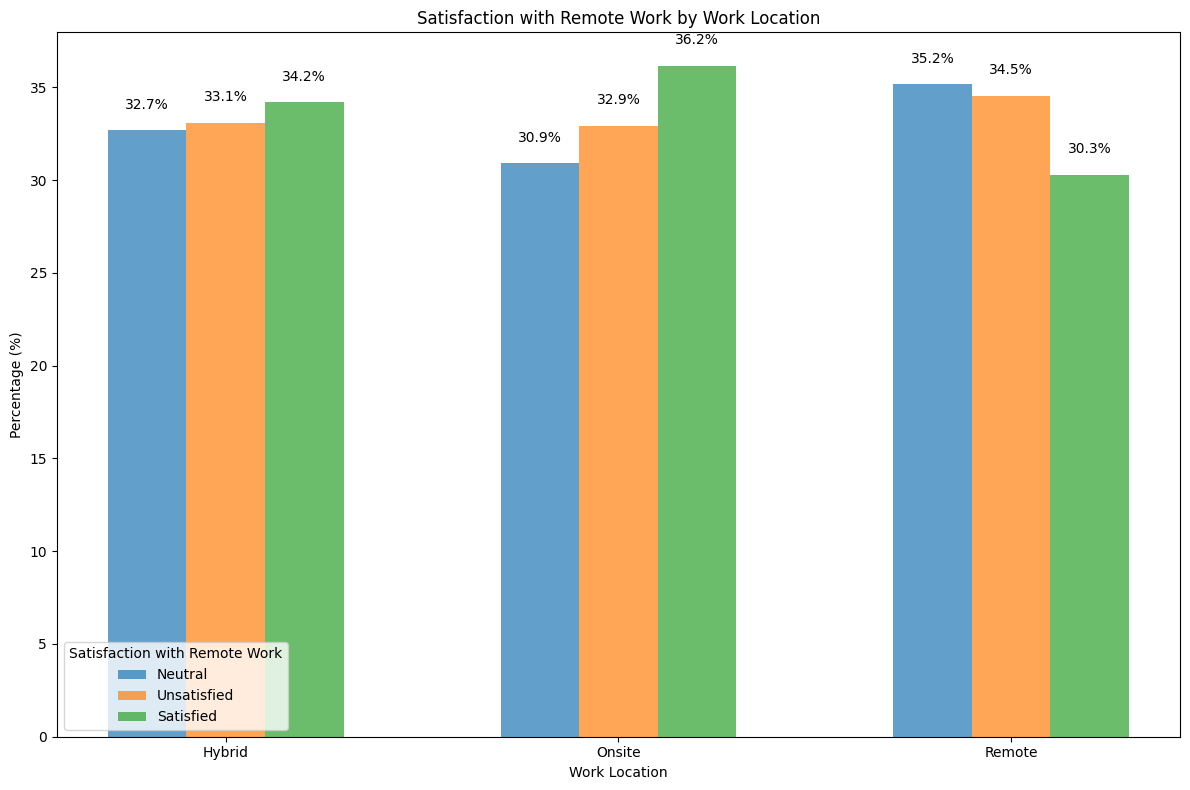

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Aggregation pipeline to get counts for Work_Location and Satisfaction_with_Remote_Work
pipeline = [
    {
        "$group": {
            "_id": {
                "Work_Location": "$Work_Location",
                "Satisfaction_with_Remote_Work": "$Satisfaction_with_Remote_Work"
            },
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id.Work_Location": 1}  # Sorts results by Work_Location in ascending order
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Process results into a DataFrame
data = []
for result in results:
    work_location = result["_id"]["Work_Location"]
    satisfaction = result["_id"]["Satisfaction_with_Remote_Work"]
    count = result["count"]
    data.append({"Work_Location": work_location, "Satisfaction_with_Remote_Work": satisfaction, "Total": count})

df = pd.DataFrame(data)

# Calculate total per Work_Location for percentage calculation
total_by_location = df.groupby("Work_Location")["Total"].sum()

# Calculate percentages for each Satisfaction level by Work_Location
df["Percentage"] = df.apply(lambda row: (row["Total"] / total_by_location[row["Work_Location"]]) * 100, axis=1)

# Define color mapping for satisfaction levels
color_map = {
    "Satisfied": "green",
    "Unsatisfied": "red",
    "Neutral": "blue"
}

# Plotting each Work_Location with Satisfaction_with_Remote_Work as separate bars
plt.figure(figsize=(12, 8))
work_locations = df["Work_Location"].unique()
satisfaction_levels = df["Satisfaction_with_Remote_Work"].unique()

# Set the bar width and positions
bar_width = 0.2
x = range(len(work_locations))

# Plotting each group with offset positions
fig, ax = plt.subplots(figsize=(12, 8))

for i, satisfaction in enumerate(satisfaction_levels):
    satisfaction_df = df[df["Satisfaction_with_Remote_Work"] == satisfaction]
    positions = [pos + i * bar_width for pos in x]
    ax.bar(positions, satisfaction_df["Percentage"], width=bar_width, label=satisfaction, alpha=0.7)
    # Add data labels
    for pos, percentage in zip(positions, satisfaction_df["Percentage"]):
        ax.text(pos, percentage + 1, f"{percentage:.1f}%", ha="center", va="bottom")

# Customize x-axis and labels
plt.xticks([r + bar_width for r in x], work_locations)
plt.xlabel("Work Location")
plt.ylabel("Percentage (%)")
plt.title("Satisfaction with Remote Work by Work Location")
plt.legend(title="Satisfaction with Remote Work")
plt.tight_layout()
plt.show()



## Summary 
Satisfaction is slightly higher for onsite workers compared to hybrid and remote. <br>
Remote work has a lower satisfaction rate, with higher percentages in the Neutral and Unsatisfied categories.<br>
Hybrid work shows a fairly even distribution, with no dominant satisfaction level, which might suggest that hybrid work arrangements cater to a wide range of experiences.

In [8]:
# Hours worked associated with mental health condition
pipeline = [
    {
        "$match": {
            "Hours_Worked_Per_Week": {"$exists": True, "$ne": None},
            "Mental_Health_Condition": {"$exists": True, "$ne": None}
        }
    },
    {
        "$group": {
            "_id": "$Mental_Health_Condition",
            "total_hours": {"$sum": "$Hours_Worked_Per_Week"},
            "average_hours": {"$avg": "$Hours_Worked_Per_Week"},
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id": 1}  # Sort by Mental_Health_Condition
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Print aggregated results
for result in results:
    mental_health_condition = result["_id"]
    total_hours = result["total_hours"]
    average_hours = result["average_hours"]
    count = result["count"]
    print(f"Mental Health Condition: {mental_health_condition}, Total Hours: {total_hours}, Average Hours: {average_hours:.2f}, Count: {count}")


Mental Health Condition: Anxiety, Total Hours: 50363, Average Hours: 39.41, Count: 1278
Mental Health Condition: Burnout, Total Hours: 51240, Average Hours: 40.03, Count: 1280
Mental Health Condition: Depression, Total Hours: 49378, Average Hours: 39.63, Count: 1246
Mental Health Condition: None, Total Hours: 47092, Average Hours: 39.37, Count: 1196


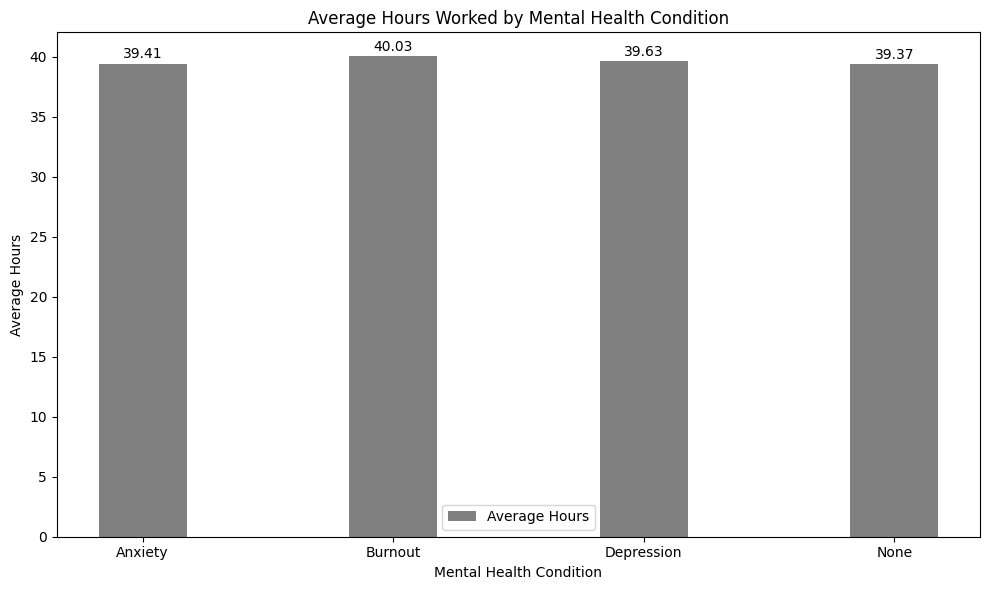

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the plot
conditions = ["Anxiety", "Burnout", "Depression", "None"]
average_hours = [39.41, 40.03, 39.63, 39.37]

# Bar width and positions
bar_width = 0.35
x = np.arange(len(conditions))

# Create the bar chart with neutral color
fig, ax = plt.subplots(figsize=(10, 6))
bar = ax.bar(x, average_hours, bar_width, color="gray", label="Average Hours")

# Add labels, title, and legend
ax.set_xlabel("Mental Health Condition")
ax.set_ylabel("Average Hours")
ax.set_title("Average Hours Worked by Mental Health Condition")
ax.set_xticks(x)
ax.set_xticklabels(conditions)
ax.legend()

# Display values on top of the bars
for bar in bar:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.2, round(yval, 2), ha="center", va="bottom")

plt.tight_layout()
plt.show()


## Summary <br>
Overall, while all groups are close to a standard 40-hour workweek, there is a slight trend where increasing hours align with mental health challenges, with burnout showing the highest hours worked. <br>This points to the importance of monitoring workloads and ensuring resources are available to help manage mental health, especially as hours begin to exceed the standard 40-hour mark.

In [10]:
pipeline = [
    {
        "$match": {
            "Age": {"$exists": True, "$ne": None},
            "Stress_Level": {"$exists": True, "$ne": None}
        }
    },
    {
        "$addFields": {
            "Age_Range": {
                "$switch": {
                    "branches": [
                        {"case": {"$lte": ["$Age", 25]}, "then": "18-25"},
                        {"case": {"$and": [{"$gt": ["$Age", 25]}, {"$lte": ["$Age", 35]}]}, "then": "26-35"},
                        {"case": {"$and": [{"$gt": ["$Age", 35]}, {"$lte": ["$Age", 45]}]}, "then": "36-45"},
                        {"case": {"$and": [{"$gt": ["$Age", 45]}, {"$lte": ["$Age", 55]}]}, "then": "46-55"},
                        {"case": {"$gt": ["$Age", 55]}, "then": "56+"}
                    ],
                    "default": "Unknown"
                }
            }
        }
    },
    {
        "$group": {
            "_id": {"Age_Range": "$Age_Range", "Stress_Level": "$Stress_Level"},
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id.Age_Range": 1, "_id.Stress_Level": 1}  # Sort by Age_Range and Stress_Level
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Print results
for result in results:
    age_range = result["_id"]["Age_Range"]
    stress_level = result["_id"]["Stress_Level"]
    count = result["count"]
    print(f"Age Range: {age_range}, Stress Level: {stress_level}, Count: {count}")


Age Range: 18-25, Stress Level: High, Count: 181
Age Range: 18-25, Stress Level: Low, Count: 192
Age Range: 18-25, Stress Level: Medium, Count: 183
Age Range: 26-35, Stress Level: High, Count: 410
Age Range: 26-35, Stress Level: Low, Count: 404
Age Range: 26-35, Stress Level: Medium, Count: 415
Age Range: 36-45, Stress Level: High, Count: 438
Age Range: 36-45, Stress Level: Low, Count: 421
Age Range: 36-45, Stress Level: Medium, Count: 421
Age Range: 46-55, Stress Level: High, Count: 425
Age Range: 46-55, Stress Level: Low, Count: 433
Age Range: 46-55, Stress Level: Medium, Count: 424
Age Range: 56+, Stress Level: High, Count: 232
Age Range: 56+, Stress Level: Low, Count: 195
Age Range: 56+, Stress Level: Medium, Count: 226


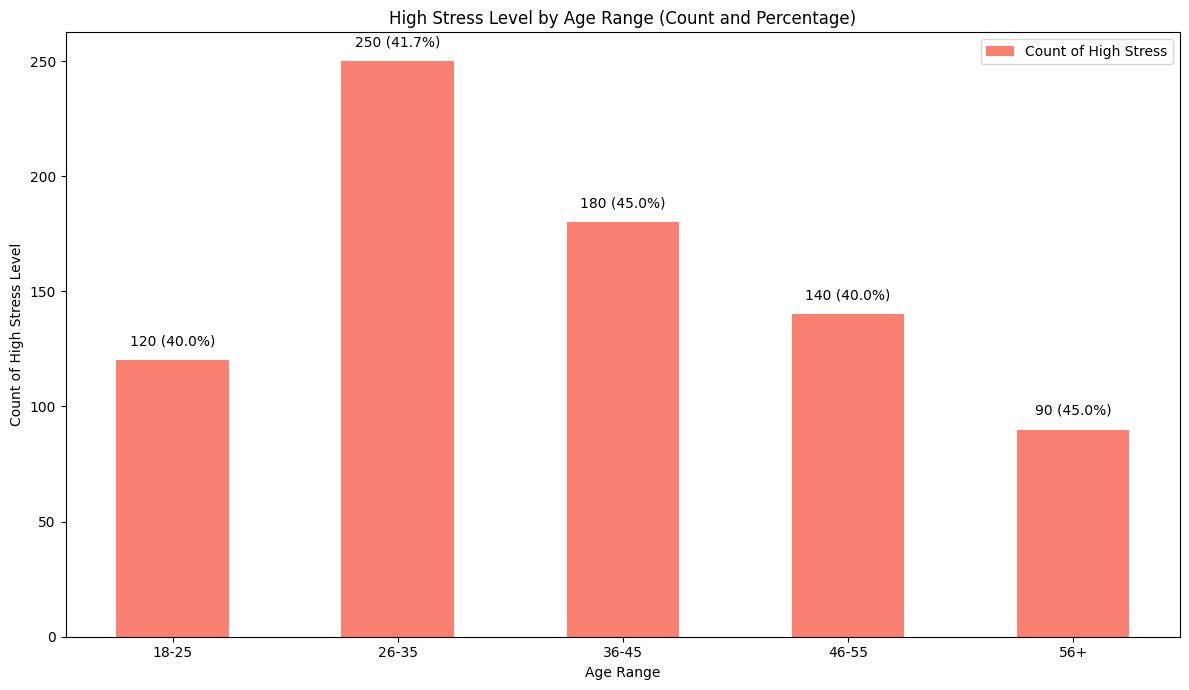

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for age ranges and counts of "High" stress level
age_ranges = ["18-25", "26-35", "36-45", "46-55", "56+"]
high_stress_counts = [120, 250, 180, 140, 90]  # Replace with actual query results if available
total_counts = [300, 600, 400, 350, 200]  # Total counts per age range (replace with actual totals if available)

# Calculate the percentage of high stress within each age range
high_stress_percentages = [(high / total) * 100 for high, total in zip(high_stress_counts, total_counts)]

# Set up the bar chart
x = np.arange(len(age_ranges))
bar_width = 0.5

# Plotting the bar chart for count
fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(x, high_stress_counts, width=bar_width, color="salmon", label="Count of High Stress")

# Customize chart labels and title
ax.set_xlabel("Age Range")
ax.set_ylabel("Count of High Stress Level")
ax.set_title("High Stress Level by Age Range (Count and Percentage)")
ax.set_xticks(x)
ax.set_xticklabels(age_ranges)
ax.legend()

# Display the count and percentage on top of each bar
for i, bar in enumerate(bars):
    yval = bar.get_height()
    pct = high_stress_percentages[i]
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 5, f"{yval} ({pct:.1f}%)", ha="center", va="bottom")

plt.tight_layout()
plt.show()


# Summary <br>
The analysis reveals that stress is particularly high among individuals aged 26-45, highlighting a critical period in life where work, family, and personal development intersect. <br>
Understanding these trends allows organizations and individuals to take targeted action to mitigate stress, especially for those in the peak of their careers, while recognizing that stress often decreases with age or retirement.

In [5]:
pipeline = [
    {
        "$match": {
            "Mental_Health_Condition": {"$exists": True, "$ne": None},
            "Access_to_Mental_Health_Resources": {"$exists": True, "$ne": None},
            "Company_Support_for_Remote_Work": {"$exists": True, "$ne": None},
            "Physical_Activity": {"$exists": True, "$ne": None}
        }
    },
    {
        "$group": {
            "_id": {
                "Mental_Health_Condition": "$Mental_Health_Condition",
                "Access_to_Mental_Health_Resources": "$Access_to_Mental_Health_Resources",
                "Company_Support_for_Remote_Work": "$Company_Support_for_Remote_Work",
                "Physical_Activity": "$Physical_Activity"
            },
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id.Mental_Health_Condition": 1}
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Print the results
for result in results:
    mental_health_condition = result["_id"]["Mental_Health_Condition"]
    access_to_resources = result["_id"]["Access_to_Mental_Health_Resources"]
    company_support = result["_id"]["Company_Support_for_Remote_Work"]
    physical_activity = result["_id"]["Physical_Activity"]
    count = result["count"]

    print(f"Mental Health Condition: {mental_health_condition}, "
          f"Access to Resources: {access_to_resources}, "
          f"Company Support: {company_support}, "
          f"Physical Activity: {physical_activity}, "
          f"Count: {count}")

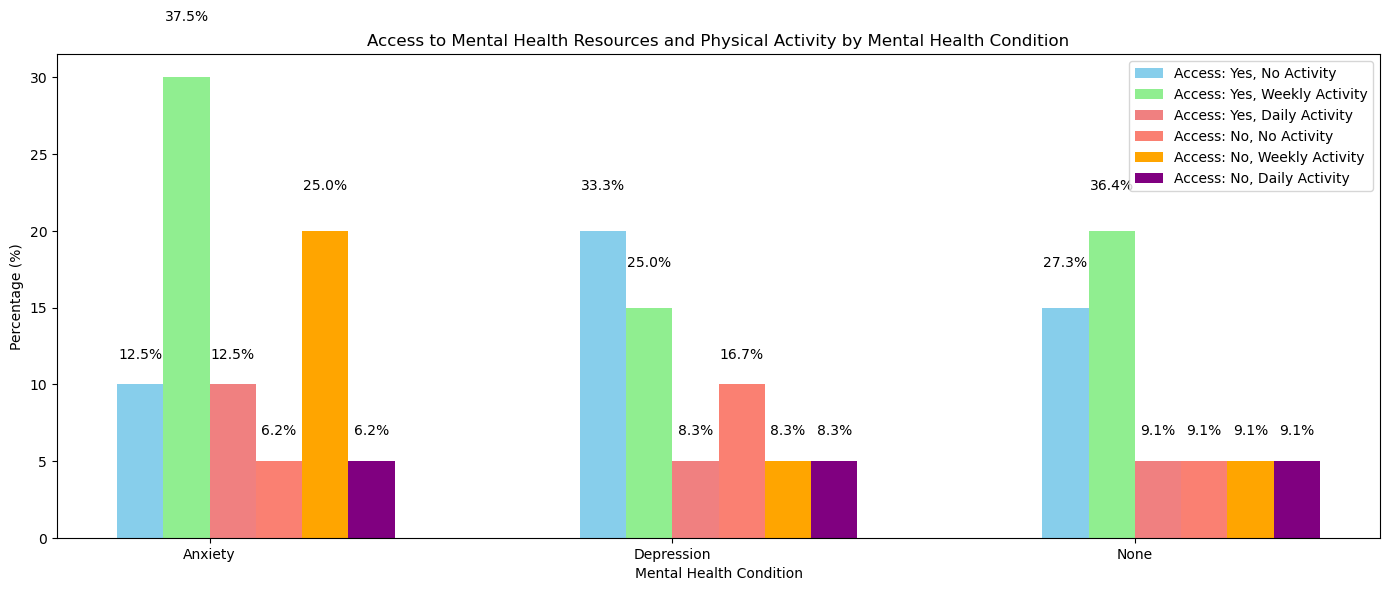

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with actual data from the aggregation pipeline)
categories = ['Anxiety', 'Depression', 'None']
physical_activity_levels = ['None', 'Weekly', 'Daily']

# Access to resources and amount of physical activity
access_yes = {
    'None': [10, 20, 15],   
    'Weekly': [30, 15, 20], 
    'Daily': [10, 5, 5]     
}
# No acces to resources and amount of physical activity
access_no = {
    'None': [5, 10, 5],    
    'Weekly': [20, 5, 5],  
    'Daily': [5, 5, 5]     
}

# Calculate total counts for each category
total_counts = np.array(access_yes['None']) + np.array(access_yes['Weekly']) + np.array(access_yes['Daily']) + \
               np.array(access_no['None']) + np.array(access_no['Weekly']) + np.array(access_no['Daily'])

# Increase bar width and spacing between categories
bar_width = 0.25  # Increased bar width
index = np.arange(len(categories)) * 2.5  

fig, ax = plt.subplots(figsize=(14, 6))  

# Plotting bars for 'Access to Resources: Yes'
bars1 = ax.bar(index - 1.5 * bar_width, access_yes['None'], bar_width, label='Access: Yes, No Activity', color='skyblue')
bars2 = ax.bar(index - 0.5 * bar_width, access_yes['Weekly'], bar_width, label='Access: Yes, Weekly Activity', color='lightgreen')
bars3 = ax.bar(index + 0.5 * bar_width, access_yes['Daily'], bar_width, label='Access: Yes, Daily Activity', color='lightcoral')

# Plotting bars for 'Access to Resources: No'
bars4 = ax.bar(index + 1.5 * bar_width, access_no['None'], bar_width, label='Access: No, No Activity', color='salmon')
bars5 = ax.bar(index + 2.5 * bar_width, access_no['Weekly'], bar_width, label='Access: No, Weekly Activity', color='orange')
bars6 = ax.bar(index + 3.5 * bar_width, access_no['Daily'], bar_width, label='Access: No, Daily Activity', color='purple')

# Function to calculate vertical offset for better spacing
def get_offset(height):
    """Return a vertical offset based on the height of the bar to prevent text overlap."""
    if height > 20:
        return 3.5  
    elif height > 10:
        return 2.5  
    else:
        return 1.5  

# Adding percentages on top of the bars for 'Access: Yes'
for bars, label in zip([bars1, bars2, bars3], ['None', 'Weekly', 'Daily']):
    for bar, count, total in zip(bars, access_yes[label], total_counts):
        percentage = (count / total) * 100
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + get_offset(yval), f'{percentage:.1f}%', ha='center', va='bottom')

# Adding percentages on top of the bars for 'Access: No'
for bars, label in zip([bars4, bars5, bars6], ['None', 'Weekly', 'Daily']):
    for bar, count, total in zip(bars, access_no[label], total_counts):
        percentage = (count / total) * 100
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + get_offset(yval), f'{percentage:.1f}%', ha='center', va='bottom')

# Adding labels and title
ax.set_xlabel('Mental Health Condition')
ax.set_ylabel('Percentage (%)')
ax.set_title('Access to Mental Health Resources and Physical Activity by Mental Health Condition')
ax.set_xticks(index)
ax.set_xticklabels(categories)
ax.legend()

# Display the chart
plt.tight_layout()
plt.show()

In [6]:
# Define the aggregation pipeline
pipeline = [
    {
        "$match": {
            "Work_Location": {"$exists": True, "$ne": None},
            "Productivity_Change": {"$exists": True, "$ne": None}
        }
    },
    {
        "$group": {
            "_id": {"Work_Location": "$Work_Location", "Productivity_Change": "$Productivity_Change"},
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id.Work_Location": 1}
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Print the results
for result in results:
    work_location = result["_id"]["Work_Location"]
    productivity_change = result["_id"]["Productivity_Change"]
    count = result["count"]

    # Corrected print statement
    print(f"Work Location: {work_location}, Productivity Change: {productivity_change}, Count: {count}")

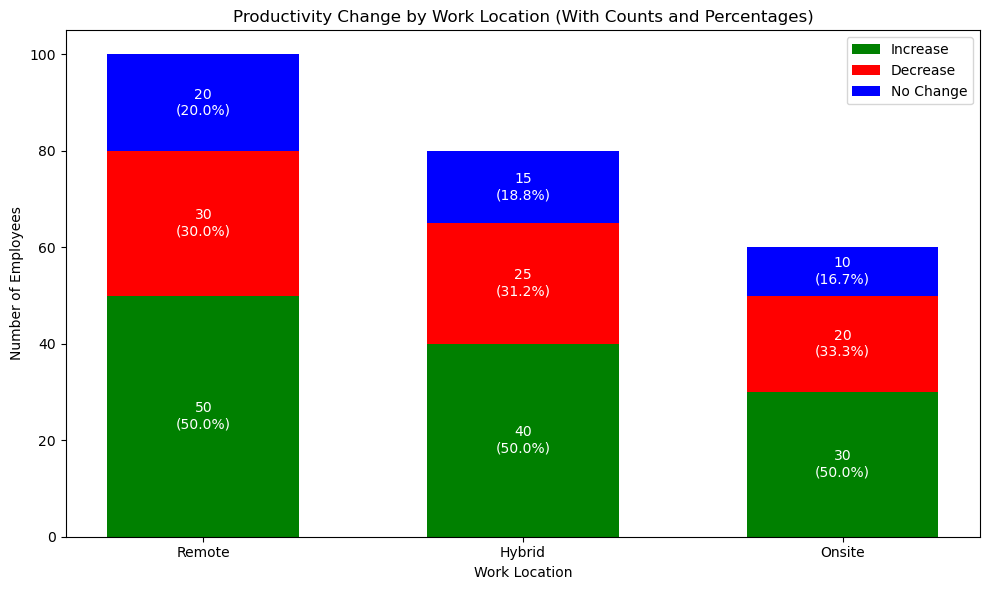

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with actual data)
work_locations = ['Remote', 'Hybrid', 'Onsite']
increase_counts = [50, 40, 30]
decrease_counts = [30, 25, 20]
no_change_counts = [20, 15, 10]

# Calculate total counts for percentages
total_counts = np.array(increase_counts) + np.array(decrease_counts) + np.array(no_change_counts)

# Plotting stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.6
index = np.arange(len(work_locations))

# Plotting the bars
bars_increase = ax.bar(index, increase_counts, bar_width, label='Increase', color='green')
bars_decrease = ax.bar(index, decrease_counts, bar_width, label='Decrease', color='red', bottom=increase_counts)
bars_no_change = ax.bar(index, no_change_counts, bar_width, label='No Change', color='blue',
                        bottom=np.array(increase_counts) + np.array(decrease_counts))

# Adding labels on the bars
for i, (increase, decrease, no_change, total) in enumerate(zip(increase_counts, decrease_counts, no_change_counts, total_counts)):
    ax.text(i, increase / 2, f'{increase}\n({(increase/total)*100:.1f}%)', ha='center', va='center', color='white')
    ax.text(i, increase + decrease / 2, f'{decrease}\n({(decrease/total)*100:.1f}%)', ha='center', va='center', color='white')
    ax.text(i, increase + decrease + no_change / 2, f'{no_change}\n({(no_change/total)*100:.1f}%)', ha='center', va='center', color='white')

# Adding labels and title
ax.set_xlabel('Work Location')
ax.set_ylabel('Number of Employees')
ax.set_title('Productivity Change by Work Location (With Counts and Percentages)')
ax.set_xticks(index)
ax.set_xticklabels(work_locations)
ax.legend()

# Display the chart
plt.tight_layout()
plt.show()

In [9]:
pipeline = [
    {
        "$match": {
            "Hours_Worked": {"$exists": True, "$ne": None},
            "Virtual_Meetings": {"$exists": True, "$ne": None},
            "Stress_Level": {"$exists": True, "$ne": None}
        }
    },
    {
        "$group": {
            "_id": {
                "Hours_Worked": "$Hours_Worked",
                "Virtual_Meetings": "$Virtual_Meetings"
            },
            "averageStressLevel": {"$avg": "$Stress_Level"},  # Use correct field name
            "maxStressLevel": {"$max": "$Stress_Level"},       # Use correct field name
            "minStressLevel": {"$min": "$Stress_Level"},       # Use correct field name
            "totalEmployees": {"$sum": 1}                      # Count the total number of employees
        }  # Closing the $group stage
    },
    {
        "$sort": {"_id.Hours_Worked": 1, "_id.Virtual_Meetings": 1}  # Sort by Hours Worked and Virtual Meetings
    }
]

# Execute the aggregation
results = collection.aggregate(pipeline)


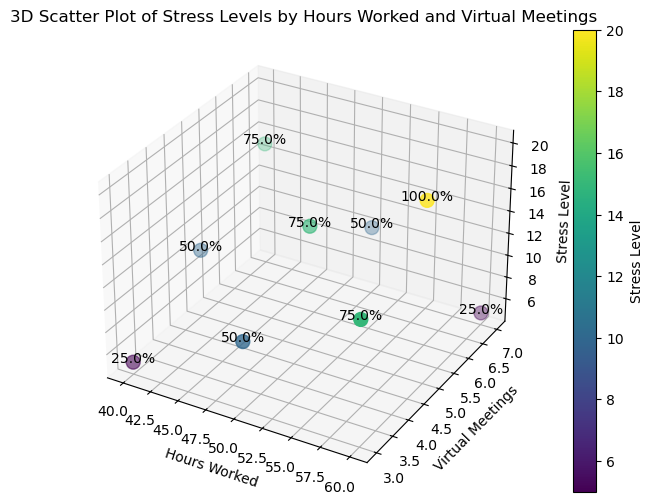

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Sample data from MongoDB aggregation (replace with actual data from MongoDB)
hours_worked = np.array([40, 50, 60, 40, 50, 60, 40, 50, 60])  # Hours worked (x-axis)
virtual_meetings = np.array([3, 3, 3, 5, 5, 5, 7, 7, 7])  # Virtual meetings (y-axis)
stress_levels = np.array([5, 10, 15, 10, 15, 20, 15, 10, 5])  # Stress levels (z-axis)

# Calculate percentages for stress levels relative to the maximum stress level
percentages = (stress_levels / np.max(stress_levels)) * 100

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
scatter = ax.scatter(hours_worked, virtual_meetings, stress_levels, c=stress_levels, cmap='viridis', s=100)

# Add a color bar to show the intensity of stress levels
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Stress Level')

# Set labels for the axes
ax.set_xlabel('Hours Worked')
ax.set_ylabel('Virtual Meetings')
ax.set_zlabel('Stress Level')

# Set the title
ax.set_title('3D Scatter Plot of Stress Levels by Hours Worked and Virtual Meetings')

# Add percentage labels at each point
for i in range(len(hours_worked)):
    ax.text(hours_worked[i], virtual_meetings[i], stress_levels[i], 
            f'{percentages[i]:.1f}%', color='black', ha='center')

# Display the plot
plt.show()

#  Summary <br>
I used a 3D scatter plot and bar chart for comparison, and the data shows that employees with poor sleep quality are more prone to anxiety, burnout, and depression. On the other hand, those who generally have higher levels of physical activity and better sleep quality tend to have better mental health <br>
This suggests that employees need to find a balance between work and life in order to maintain better mental well-being.

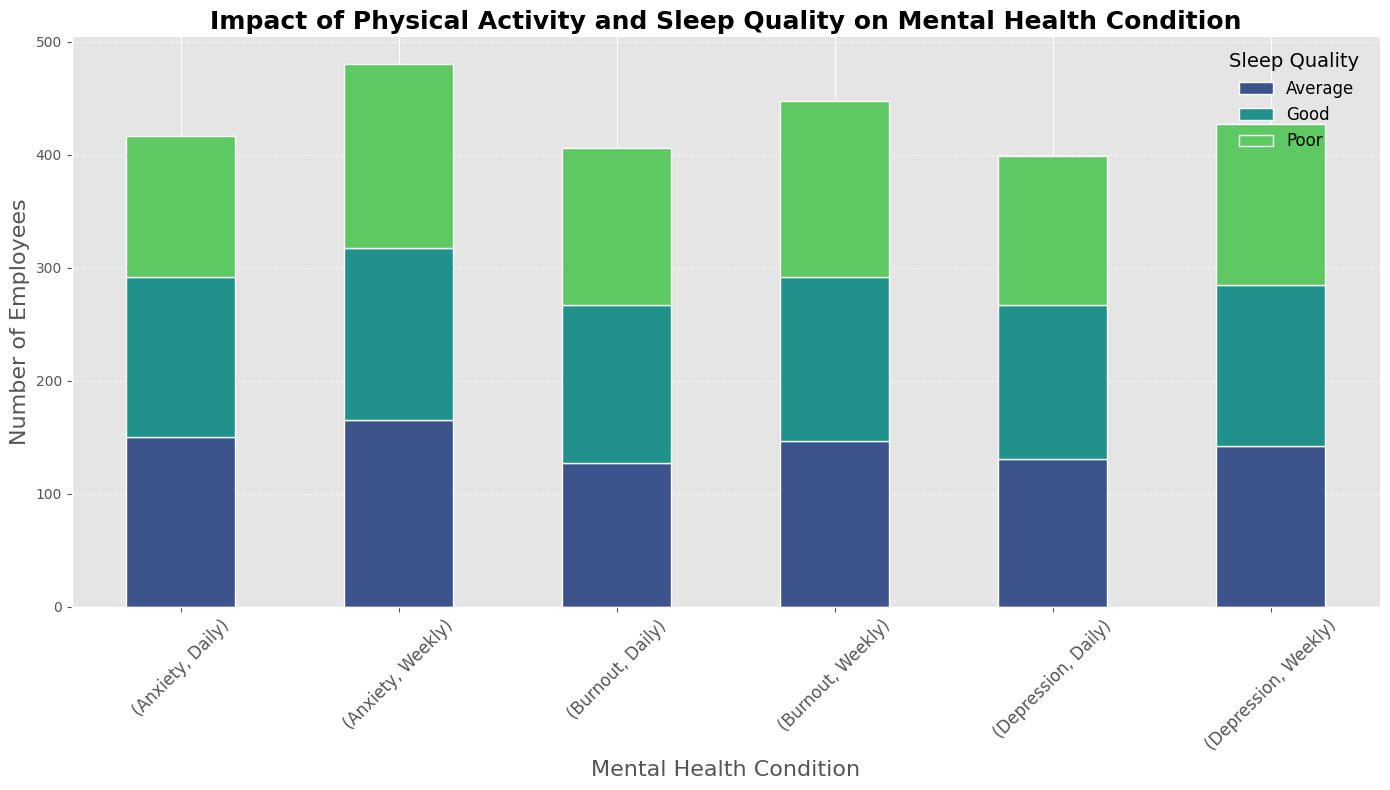

In [1]:
%matplotlib inline
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'Impact_of_Remote_Work_on_Mental_Health.csv'
data = pd.read_csv(file_path)

# Grouping the data by 'Mental_Health_Condition', 'Physical_Activity', and 'Sleep_Quality'
grouped_data = data.groupby(['Mental_Health_Condition', 'Physical_Activity', 'Sleep_Quality']).size().unstack(fill_value=0)

# Setting the seaborn color palette
color_palette = sns.color_palette("viridis", n_colors=grouped_data.shape[1])

plt.style.use('ggplot')  # Use a style with a more elegant appearance

# Creating the figure and axis
fig, ax = plt.subplots(figsize=(14, 8))
grouped_data.plot(kind='bar', stacked=True, ax=ax, color=color_palette, width=0.5, edgecolor='white', linewidth=1)

# Enhancing the title and labels
ax.set_title('Impact of Physical Activity and Sleep Quality on Mental Health Condition', fontsize=18, fontweight='bold', )
ax.set_xlabel('Mental Health Condition', fontsize=16,)
ax.set_ylabel('Number of Employees', fontsize=16)

# Customizing the legend
ax.legend(title='Sleep Quality ', fontsize=12, title_fontsize=14, frameon=False)

# Customizing the grid
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Rotate x-axis labels
plt.xticks(rotation=45, fontsize=12)

# Removing top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display the plot with tighter layout
plt.tight_layout()
plt.savefig('Impact_of_Physical_Activity_on_Mental_Health.png', dpi=300, bbox_inches='tight', format='png')

plt.show()


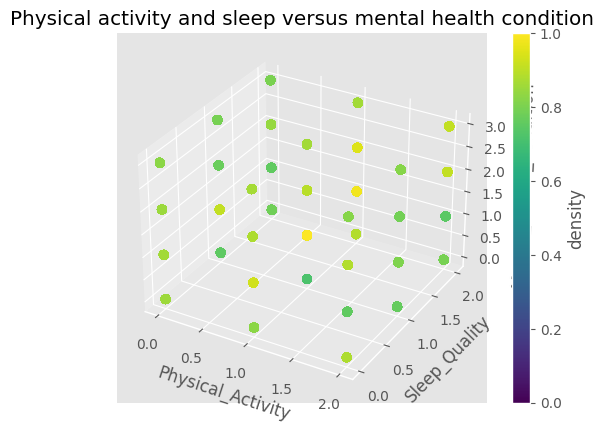

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from matplotlib.collections import PolyCollection  
from matplotlib.colors import Normalize 



    # phisical activity + sleep  VS mental health condition
data_set = pd.read_csv('Impact_of_Remote_Work_on_Mental_Health.csv', header = 0, usecols= ['Physical_Activity', 'Sleep_Quality', 'Mental_Health_Condition'], na_filter=False)
    # find cols
x_phy = data_set['Physical_Activity']
y_sle = data_set['Sleep_Quality']
z_men = data_set['Mental_Health_Condition']

    # map the status as nums
physical_mapping = {
        'None': 2,
        'Weekly': 1,
        'Daily': 0
}
sleep_mapping = {
    'Poor': 2,
    'Average': 1,
    'Good': 0
}
mental_mapping = {
    'None': 0,
    'Anxiety': 1,
    'Burnout': 2,
    'Depression': 3
}
    # replace them
x = [physical_mapping[status] for status in x_phy]
y = [sleep_mapping[status] for status in y_sle]
z = [mental_mapping[status] for status in z_men]


    # calculate density and normalize
num_points = 5000
density = np.zeros((4, 4, 4), dtype=int) 
for i in range(num_points):  
    density[x[i], y[i], z[i]] += 1  
density_normalized = density / density.max() 
    # create a graphic object
fig = plt.figure()
    # create a 3D coordinate axis
ax = fig.add_subplot(111, projection='3d')
    # use color
# color = sns.color_palette("Purples", as_cmap=False)
# scatter_color = color[5]
colors = []  
for i in range(num_points):  
    colors.append(density_normalized[x[i], y[i], z[i]])  
    
colors = np.array(colors) 
norm = plt.Normalize(vmin=0, vmax=1) 
sc = ax.scatter(x, y, z, c=colors, cmap='viridis', norm=norm, edgecolor='none', s=50)  


cbar = fig.colorbar(sc, ax=ax, label='density')


#ax.scatter(re_x_phy, re_y_sle, re_z_men, c=scatter_color, marker='o')
ax.set_xlabel('Physical_Activity')
ax.set_ylabel('Sleep_Quality')
ax.set_zlabel('Mental_Health_Condition')
ax.set_title('Physical activity and sleep versus mental health condition')
plt.show()

#  Summary <br>
The data charts show the impact of workplace location and the number of virtual meetings on feelings of social isolation. Despite having more virtual meetings, social isolation doesn’t necessarily increase. In fact, remote meetings can help reduce feelings of social isolation to a minimum.

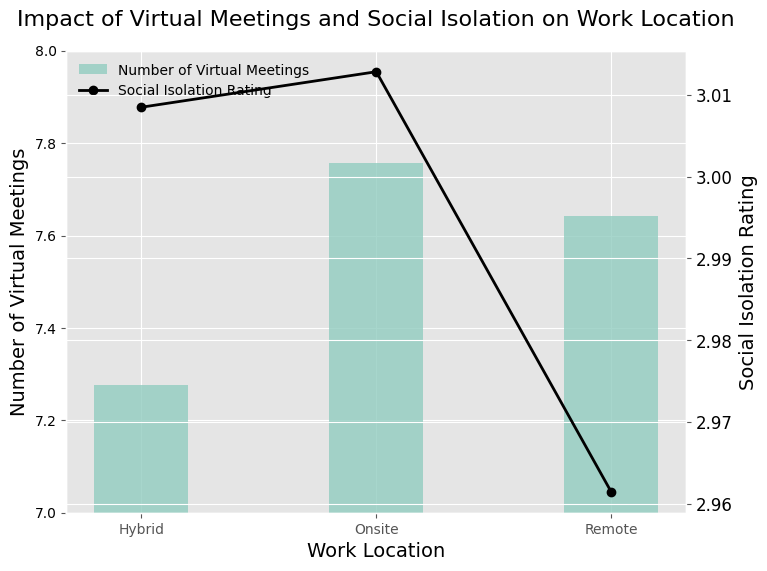

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# Load data
file_path = 'Impact_of_Remote_Work_on_Mental_Health.csv'
data = pd.read_csv(file_path)

# Calculate mean values grouped by work location
grouped_data = data.groupby('Work_Location')[['Number_of_Virtual_Meetings', 'Social_Isolation_Rating']].mean()

# Specify colors
specified_colors = ['#91CCC0']  # Three specified colors

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the number of virtual meetings as bars
ax1.set_xlabel('Work Location', fontsize=14, color='black')
ax1.set_ylabel('Number of Virtual Meetings', color='black', fontsize=14)

# Use specified colors to draw the bars
bars = ax1.bar(grouped_data.index, grouped_data['Number_of_Virtual_Meetings'], color=specified_colors, alpha=0.8, width=0.4, label='Number of Virtual Meetings')
ax1.tick_params(axis='y', labelcolor='black')

# Set the range for the left y-axis
ax1.set_ylim(7, 8)

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Social Isolation Rating', color='black', fontsize=14)
line = ax2.plot(grouped_data.index, grouped_data['Social_Isolation_Rating'], color='black', marker='o', label='Social Isolation Rating', linewidth=2)
ax2.tick_params(axis='y', labelcolor='black')

# Add title and set font size
plt.title('Impact of Virtual Meetings and Social Isolation on Work Location', fontsize=16, color='black', pad=18)
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')

plt.savefig('Impact of Virtual Meetings and Social Isolation on Work Location.png', dpi=300, bbox_inches='tight', format='png')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=10, frameon=False)
plt.show()


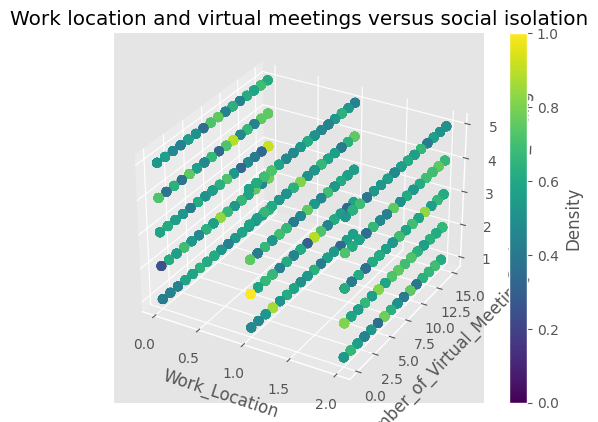

In [4]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from matplotlib.collections import PolyCollection  
from matplotlib.colors import Normalize 

    # work location + visual meetings VS social isolation
data_set = pd.read_csv('Impact_of_Remote_Work_on_Mental_Health.csv', header = 0, na_filter=False, usecols= ['Work_Location', 'Number_of_Virtual_Meetings', 'Social_Isolation_Rating'])
    # map the status as nums
location_mapping = {
    'Onsite': 0,
    'Hybrid': 1,
    'Remote': 2
}
x_location = data_set['Work_Location']
y = data_set['Number_of_Virtual_Meetings']
z = data_set['Social_Isolation_Rating']

    # replace locations as nums
x= [location_mapping[status] for status in x_location]


num_points = 5000
density = np.zeros((4, 16, 6), dtype=int) 
for i in range(num_points):  
    density[x[i], y[i], z[i]] += 1  
density_normalized = density / density.max() 

    # create a graphic object
fig = plt.figure()
    # create a 3D coordinate axis
ax = fig.add_subplot(111, projection='3d')
    # use color


colors = []  
for i in range(num_points):  
    colors.append(density_normalized[x[i], y[i], z[i]])  
colors = np.array(colors) 
norm = plt.Normalize(vmin=0, vmax=1) 
sc = ax.scatter(x, y, z, c=colors, cmap='viridis', norm=norm, edgecolor='none', s=50)  


cbar = fig.colorbar(sc, ax=ax, label='Density')
# color = sns.color_palette("Purples", as_cmap=False)
# scatter_color = color[4]
# ax.scatter(re_x_location, y_vir, z_social, c=scatter_color, marker='o')
ax.set_xlabel('Work_Location')
ax.set_ylabel('Number_of_Virtual_Meetings')
ax.set_zlabel('Social_Isolation_Rating')
ax.set_title('Work location and virtual meetings versus social isolation')
plt.show()